In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as fun
import seaborn as sns

# Read Data and Process Data

In [2]:
ca_whole_ml = pd.read_csv('ca_whole.csv')

In [3]:
# Drop Outlier
max_aqi_ml = np.mean(ca_whole_ml['AQI'])+2*np.std(ca_whole_ml['AQI'])
min_aqi_ml = np.mean(ca_whole_ml['AQI'])-2*np.std(ca_whole_ml['AQI'])
ca_whole_ml = ca_whole_ml.loc[ca_whole_ml['AQI']<=max_aqi_ml]

Drop Outlier to avoid influence from Outliers

In [4]:
y_ml = ca_whole_ml.loc[:,['AQI']]
X_ml= ca_whole_ml.drop(columns = ['County Name', 'Date Local','Category','AQI'])

In [5]:
# Split Data for Train(0.9) and Test(0.1)
X_train_ml_np, X_test_ml_np, y_train_ml_np, y_test_ml_np = train_test_split(X_ml, y_ml, test_size=0.1)
X_train_ml = torch.tensor(X_train_ml_np.values.astype(np.float32))
X_test_ml = torch.tensor(X_test_ml_np.values.astype(np.float32))
y_train_ml = torch.tensor(y_train_ml_np.values.astype(np.float32))
y_test_ml = torch.tensor(y_test_ml_np.values.astype(np.float32))

# Create Model

In [6]:
# One Hidden Layer of Fully Connected Model
class mlmodel(nn.Module):
    def __init__(self):
        super(mlmodel, self).__init__()
        self.fc1   = nn.Linear(18, 10)
        self.fc2  = nn.Linear(10, 1)
            
    def forward(self, y):
        y = fun.relu(self.fc1(y))
        y = self.fc2(y)
        return y
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

# Validation for Learning Rate

In [7]:
valid_rmse = [None] * 6
learning_rates = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

for i in range(len(learning_rates)):
    rmse = 0
    learning_rate = learning_rates[i]
    for j in range(5):
        model = mlmodel()
        # Set up valid train sets
        X_valid_train, X_valid, y_valid_train, y_valid = train_test_split(X_train_ml, y_train_ml, test_size=0.2)
        for t in range(4000):
            # Forward pass
            model.eval()
            y_pred = model(X_valid_train)

            # Compute loss.
            loss = RMSELoss(y_pred, y_valid_train)
            # Zero gradients
            model.zero_grad()

            # Backward pass
            loss.backward()

            # Update weights
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad
        # Calculate validation rmse
        y_pred = model(X_valid)
        rmse = (rmse + RMSELoss(y_pred, y_valid).item())/5
    # Store validation rmse
    valid_rmse[i] = rmse
valid_rmse

[8.218397949218751,
 8.56629735595703,
 13.048397454833983,
 4.615678133544922,
 4.783288123168946,
 6.834144726562501]

In [8]:
learning_rate = learning_rates[valid_rmse.index(np.min(valid_rmse))]
learning_rate

0.001

By using validation, we could find out that learning rate $=0.001$ could provide us with the minimum learning rate. So, we will use learning rate $=0.0001$ for the rest training 

# Train

In [9]:
model_ml = mlmodel()
train_loss_ml = [None]*4000
test_loss_ml = [None]*4000
for t in range(4000):
    # Forward pass
    model.eval()
    y_pred_ml = model(X_train_ml)

    # Compute loss.
    loss_ml = RMSELoss(y_pred_ml, y_train_ml)
    # Store Loss
    train_loss_ml[t] = loss_ml.item()
    test_loss_ml[t] = RMSELoss(model(X_test_ml), y_test_ml).item()
    
    # Zero the gradients.
    model.zero_grad()
    
    # Backward pass
    loss_ml.backward()

    # Update weights
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# Plots of the Result

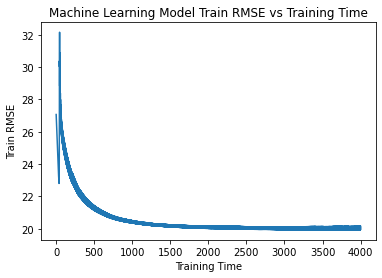

In [10]:
x_ml = np.arange(4000)
plt.plot(x_ml,train_loss_ml)
plt.title("Machine Learning Model Train RMSE vs Training Time")
plt.xlabel("Training Time")
plt.ylabel("Train RMSE")
plt.show()

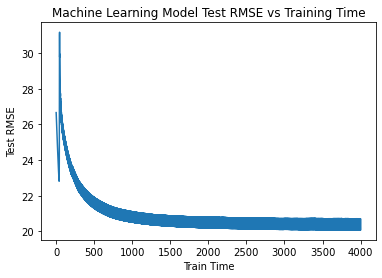

In [11]:
plt.plot(x_ml,test_loss_ml)
plt.title("Machine Learning Model Test RMSE vs Training Time")
plt.xlabel("Train Time")
plt.ylabel("Test RMSE")
plt.show()

In [12]:
print(train_loss_ml[-1])
print(test_loss_ml[-1])

20.152544021606445
20.0789737701416


It is clear that with the training time increase, both the Train RMSE and Test RMSE decreaseses. Note that both the Train RMSE and Test RMSE stop decrease dramatically after $1500$ epoches.

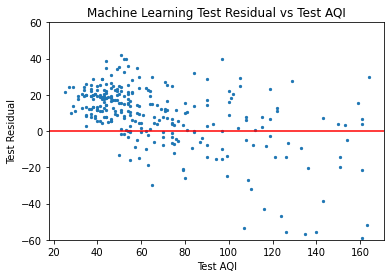

In [13]:
y_pred_ml = model(X_test_ml)
residual_train_ml = y_pred_ml - y_test_ml
plt.scatter(y_test_ml.detach().numpy(), residual_train_ml.detach().numpy(), s=5)
plt.axhline(0, color ='Red')
plt.title("Machine Learning Test Residual vs Test AQI")
plt.xlabel("Test AQI")
plt.ylabel("Test Residual")
plt.ylim([-60,60])
plt.show()

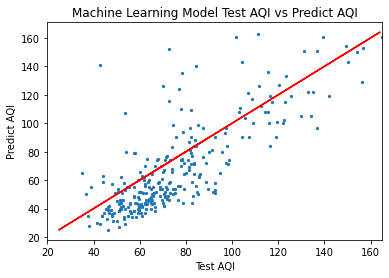

In [14]:
plt.scatter(y_pred_ml.detach().numpy(), y_test_ml.detach().numpy(),s=5)
plt.plot(y_test_ml.detach().numpy(),y_test_ml.detach().numpy(), color='red')
plt.title("Machine Learning Model Test AQI vs Predict AQI")
plt.xlabel("Test AQI")
plt.ylabel("Predict AQI")
plt.xlim([20, 165])
plt.show()

The distribution of Test RMSE and Test AQI is random enough that we could say over model does not either underfit or overfit the data.

The distribution of Test AQI vs Predict AQI also support this conclusion.

The ML model is not influenced by the value of Test AQI.

#### Help function for Heat Map Residual

In [15]:
def bucket_data_residual(table, aggfunc, resolution):
    long_buckets = np.sort(np.linspace(table['Longitude'].min(), table['Longitude'].max(), num = resolution, endpoint = False))
    lat_buckets = np.sort(np.linspace(table['Latitude'].min(), table['Latitude'].max(), num=resolution, endpoint=False))
    
    long_buckets_map = dict(list(zip(long_buckets, np.around(long_buckets,decimals=2))))
    lat_buckets_map = dict(list(zip(lat_buckets, np.around(lat_buckets,decimals=2))))
    
    get_lat_bucket_num = lambda loc: lat_buckets_map.get(lat_buckets[lat_buckets <= loc].max())
    get_long_bucket_num = lambda loc: long_buckets_map.get(long_buckets[long_buckets <= loc].max())
    
    table['lat_bucket'] = table['Latitude'].apply(get_lat_bucket_num)
    table['long_bucket'] = table['Longitude'].apply(get_long_bucket_num)
    
    pivot_cols = ['lat_bucket','long_bucket','residual']
    
    return pd.pivot_table(table[pivot_cols], index = 'lat_bucket', columns = 'long_bucket', aggfunc = aggfunc)

#### Plot Train Residual vs Position Heat Map for Machine Learning Model

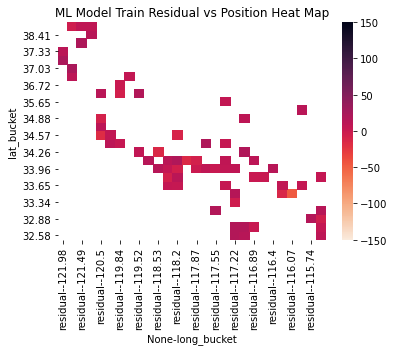

In [16]:
residual_train_ml = X_train_ml_np.loc[:,['Latitude', 'Longitude']].copy()
residual_train_ml.loc[:,"residual"] = (model(X_train_ml)-y_train_ml).detach().numpy().ravel().tolist()
heatmap_data = bucket_data_residual(residual_train_ml, np.mean, 40)
ax = sns.heatmap(heatmap_data, vmin=-150, vmax=150, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.title("ML Model Train Residual vs Position Heat Map")
plt.show()

#### Plot Test Residual vs Position Heat Map for Machine Learning Model

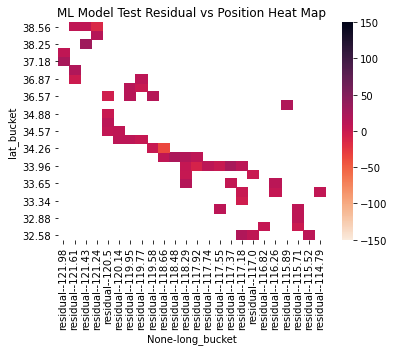

In [17]:
residual_test_ml = X_test_ml_np.loc[:,['Latitude', 'Longitude']].copy()
residual_test_ml.loc[:,"residual"] = (model(X_test_ml)-y_test_ml).detach().numpy().ravel().tolist()
heatmap_data = bucket_data_residual(residual_test_ml, np.mean, 40)
ax = sns.heatmap(heatmap_data, vmin=-150, vmax=150, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.title("ML Model Test Residual vs Position Heat Map")
plt.show()

#### Plot Total Residual vs Position for ML Model

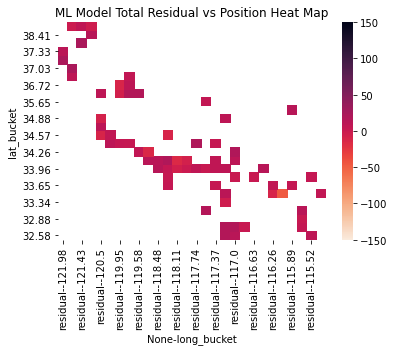

In [18]:
residual_ml = pd.concat([residual_train_ml, residual_test_ml])
heatmap_data = bucket_data_residual(residual_ml, np.mean, 40)
ax = sns.heatmap(heatmap_data, vmin=-150, vmax=150, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.title("ML Model Total Residual vs Position Heat Map")
plt.show()

By viewing the three heat maps above. There is no pattern between residual and position. 
The negative and positive residual distribute normally.
However, in some particular blocks, we could find the residual has a really large abosulute value. For instance, $(33.34-33.65, 116.26-115.89)$ has a residual near $-79$. However, by exploring the data, we did not find any cause of this issue.